# Übungsblatt 5 #

### Alice Ziegler, Daniel Schneider ###

## Aufgabe 5.1: Regression ##

#### Laden und Vorbereiten des `Wilt`-Datensatzes ####

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
training = pd.read_csv("wilt/training.csv")
testing = pd.read_csv("wilt/testing.csv")

In [3]:
training['class'] = training['class'].astype(dtype="category")
testing['class'] = testing['class'].astype(dtype="category")

In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 6 columns):
class         4339 non-null category
GLCM_pan      4339 non-null float64
Mean_Green    4339 non-null float64
Mean_Red      4339 non-null float64
Mean_NIR      4339 non-null float64
SD_pan        4339 non-null float64
dtypes: category(1), float64(5)
memory usage: 173.8 KB


In [5]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
class         500 non-null category
GLCM_pan      500 non-null float64
Mean_Green    500 non-null float64
Mean_Red      500 non-null float64
Mean_NIR      500 non-null float64
SD_pan        500 non-null float64
dtypes: category(1), float64(5)
memory usage: 20.1 KB


### a) Lernen einer Regressionsfunktion ###

In [6]:
def regression(data,targetAttribute):
            
    t = data[[targetAttribute]].as_matrix()
    #print(t)
    
    D = data.drop([targetAttribute],axis=1).as_matrix()
    ones = np.ones((D.shape[0]))
    #print(ones)
    
    D = np.c_[ones,D]
    #print(D)
    
    DT = np.transpose(D)
    
    w = np.dot(np.dot(np.linalg.inv(np.dot(DT, D)), DT), t)
    #print(w)
    return (w)

In [7]:
def calculateValues(data, ws):
    Xs = data.as_matrix()
    ones = np.ones((Xs.shape[0]))
    
    Xs = np.c_[ones,Xs]
        
    t = np.dot(Xs, ws)
    #print(t)
    return(t)

In [8]:
w = regression(training.iloc[:,1:6],'SD_pan')

In [9]:
ts = testing[['SD_pan']].as_matrix()

In [10]:
tsCalc = calculateValues(testing.iloc[:,1:5],w)

### b) MDS ###

In [11]:
def groupByClasses(data,classAttribute):
    cats = data[classAttribute].cat.categories
    
    dataClass = [None]*len(cats)
    
    for i in range(0,len(cats)):
        dataClass[i] = data.loc[data[classAttribute] == cats[i]]
    
    return(dataClass)

In [12]:
def regressionWithClasses(data,targetAttribute,classAttribute):
    
    datas = groupByClasses(data,classAttribute)
    w = [None]*len(datas)
    
    for i in range(0,len(datas)):        
        w[i] = regression(datas[i].drop([classAttribute],axis=1),targetAttribute)
    
    return (w)

In [13]:
wClasses = regressionWithClasses(training,'SD_pan','class')

In [14]:
testingClasses = groupByClasses(testing,'class')

In [15]:
tsClasses = [None]*len(testingClasses)
tsCalcClasses = [None]*len(testingClasses)

for i in range(0,len(testingClasses)):
    tsClasses[i] = testingClasses[i][['SD_pan']].as_matrix()
    tsCalcClasses[i] = calculateValues(testingClasses[i].iloc[:,1:5],wClasses[i])

### c) Stress ###

In [16]:
def squareError(tLearned,tOrig):
    err = 0.5*np.sum(np.square(tLearned-tOrig))
    print(err)

In [17]:
squareError(tsCalc,ts)

16676.6852235


In [18]:
for i in range(0,len(testingClasses)):
    squareError(tsCalcClasses[i],tsClasses[i])

12323.7864823
2396.73156755


## Aufgabe 4.2: Entscheidungsbäume ##

### a) Konstruktion des Baums ###

### b) Anwendung des Baumes ###

## Aufgabe 4.3: kNN ##

### a) k-Nearest-Neighbors ###

In [93]:
def dist(x,y,dtypes,columns,normalize):
    
    dist = 0
    for f in range(len(columns)):
        
        if dtypes[f].name == "category":
            if x[attribs[f]].cat.ordered:
                dist += distOrdinal(x[columns[f]],y[columns[f]])
            else:
                dist += distNominal(x[columns[f]],y[columns[f]])
        else:
            dist += distNumeric(x[columns[f]],y[columns[f]],normalize[f])
    
    return dist

In [94]:
def distOrdinal(x,y):
    rankCount = len(x.cat.categories)
    
    rankX = (int(x.cat.codes))/(rankCount - 1)
    rankY = (int(y.cat.codes))/(rankCount - 1)    
    dist = abs(rankX - rankY)
    
    return dist

In [95]:
def distNominal(x,y):
    if x == y:
        dist = 0
    else:
        dist = 1
    
    return dist

In [96]:
def distNumeric(x,y,normalize):
    dist = abs(float(x) - float(y))/(normalize)
    
    return dist

In [97]:
def metadata(data):
    types = data.dtypes
    columns = data.columns
    
    mins = data.min(axis=0)
    maxs = data.max(axis=0)
    normalize = (maxs - mins)
    
    return types,columns,normalize

In [165]:
def distMatrix(training,testing,excludeAttributes):
    training = training.drop([excludeAttributes],axis=1)
    testing = testing.drop([excludeAttributes],axis=1)
    
    if training.equals(testing):
        symetrical = True
    else:
        symetrical = False
    
    types,columns,normalize = metadata(training)
        
    array = np.empty([training.shape[0], testing.shape[0]])
        
    for i in range(training.shape[0]):        
        for j in range(testing.shape[0]):
            if (symetrical and j < i):
                array[i,j] = array[j,i]
            else:
                array[i,j] = (dist(training.iloc[[i]],testing.iloc[[j]],types,columns,normalize))
        
    return array

In [236]:
def kNN(training, testing, distances, classAttribute, k):
    trainingNoClass = training.drop([classAttribute],axis=1)
    testingNoClass = testing.drop([classAttribute],axis=1)
    
    classes = [None]*testingNoClass.shape[0]
    
    #types,columns,normalize = metadata(trainingNoClass)
    
    for i in range(testingNoClass.shape[0]):
        #te = testingNoClass.iloc[[i]]
        
        nearestDist = [float('inf')]*k
        nearestClasses = [None]*k
        #nearestIDs = [None]*k
        
        for j in range(trainingNoClass.shape[0]):
            #tr = trainingNoClass.iloc[[j]]
            
            d = distances[j,i]
            
            for h in range(k-1,-1,-1):
                #print (h)
                if d < nearestDist[h]:
                    if h+1 < k:
                        nearestDist[h+1] = nearestDist[h]
                        nearestClasses[h+1] = nearestClasses[h]
                        #nearestIDs[h+1] = nearestIDs[h]
                    nearestDist[h] = d
                    nearestClasses[h] = training.loc[j,classAttribute]
                    #nearestIDs[h] = j
                    
                    #print(nearestDist, nearestClasses)#, nearestIDs)
        
        classes[i] = max(set(nearestClasses), key=nearestClasses.count)
        #print(classes[i])
        
    return classes       

In [222]:
def kNNnoDist(training, testing, classAttribute, k):
    trainingNoClass = training.drop([classAttribute],axis=1)
    testingNoClass = testing.drop([classAttribute],axis=1)
    
    classes = [None]*testingNoClass.shape[0]
    
    types,columns,normalize = metadata(trainingNoClass)
    
    for i in range(testingNoClass.shape[0]):
        te = testingNoClass.iloc[[i]]
        
        nearestDist = [float('inf')]*k
        nearestClasses = [None]*k
        #nearestIDs = [None]*k
        
        for j in range(0,trainingNoClass.shape[0]):
            tr = trainingNoClass.iloc[[j]]
            
            d = dist(tr,te,types,columns,normalize)
            
            for h in range(k-1,-1,-1):
                if d < nearestDist[h]:
                    if h+1 < k:
                        nearestDist[h+1] = nearestDist[h]
                        nearestClasses[h+1] = nearestClasses[h]
                        #nearestIDs[h+1] = nearestIDs[h]
                    
                    nearestDist[h] = d
                    nearestClasses[h] = training.loc[j,classAttribute]
                    #nearestIDs[h] = j
        
        classes[i] = max(set(nearestClasses), key=nearestClasses.count)
        #print(classes[i])
        
    return classes       

### b) Testen des Algorithmus ###

In [138]:
def error(tCalc,tOrig):
    err = 0
    
    for i in range(len(tCalc)):
        if tCalc[i] != tOrig[i]:
            err += 1
    
    return err

In [166]:
distances = distMatrix(training, testing, 'class')

In [184]:
testingClasses = testing['class']

In [224]:
resultk1 = kNN(training,testing,distances,'class',1)

In [177]:
resultk3 = kNN(training,testing,distances,'class',3)

In [178]:
resultk5 = kNN(training,testing,distances,'class',5)

In [248]:
err1 = error(resultk1,testingClasses)
err1

145

In [249]:
err3 = error(resultk3,testingClasses)
err3

166

In [250]:
err5 = error(resultk5,testingClasses)
err5

174

### c) Klassifizierer mit Greedy-Ansatz ###

In [26]:
import random

In [206]:
def kNNGreedy(training,classAttribute):
    trainingNoClass = training.drop([classAttribute],axis=1)
    
    #z = pd.DataFrame([])
    zIndexes = []
    lastZ = None
    
    types,columns,normalize = metadata(trainingNoClass)
    
    while zIndexes != lastZ:
        lastZ = zIndexes
        
        #trainingRand = training.reindex(np.random.permutation(training.index))
        
        for i in np.random.permutation(training.index):
            tI = training.iloc[[i]]

            if not zIndexes:
                #z = z.append(tI, ignore_index=True)
                zIndexes.append(i)

            tINoClass = tI.drop([classAttribute],axis=1)
            #zNoClass = z.drop([classAttribute],axis=1)

            minDist = float('inf')
            minDistClass = [None]
            #minDistID = [None]

            for j in range(len(zIndexes)):
                zJ = trainingNoClass.iloc[[zIndexes[j]]]
                d = dist(tINoClass,zJ,types,columns,normalize)

                if d < minDist:
                    minDist = d
                    minDistClass = training.loc[zIndexes[j], classAttribute]
                    #minDistID = j

            if(tI.iloc[0][classAttribute] != minDistClass):
                #z = z.append(tI, ignore_index=True)
                zIndexes.append(i)
                #print(zIndexes)
    return zIndexes

In [207]:
trainingReducedIndexes = kNNGreedy(training,'class')

In [213]:
trainingReducedIndexes.sort()

In [233]:
trainingReduced = training.iloc[trainingReducedIndexes]
trainingReduced.reset_index(drop=True, inplace=True)
distancesReduced = distances[trainingReducedIndexes,:]

In [234]:
trainingReduced

,class,GLCM_pan,Mean_Green,Mean_Red,Mean_NIR,SD_pan
0,w,120.362774,205.500000,119.395349,416.581395,20.676318
1,w,124.739583,202.800000,115.333333,354.333333,16.707151
2,w,127.946309,178.368421,92.368421,278.473684,14.977453
3,w,135.431548,197.000000,112.690476,532.952381,17.604193
4,w,135.436282,184.500000,95.142857,309.190476,13.055264
5,w,131.127161,232.784314,144.588235,563.843137,11.948563
6,w,134.498092,210.212121,116.909091,594.848485,27.937685
7,w,131.164773,206.681818,114.727273,483.045455,22.903544
8,w,122.631902,230.560976,142.195122,473.707317,24.521889
9,w,113.656180,213.107143,129.785714,480.857143,29.237766


In [154]:
#trainingReduced = kNNGreedy(training,'class')

  class    GLCM_pan  Mean_Green    Mean_Red    Mean_NIR     SD_pan
0     n  142.176113  215.483871   96.693548  496.677419  28.103162
1     w  131.164773  206.681818  114.727273  483.045455  22.903544
  class    GLCM_pan  Mean_Green    Mean_Red    Mean_NIR     SD_pan
0     n  142.176113  215.483871   96.693548  496.677419  28.103162
1     w  131.164773  206.681818  114.727273  483.045455  22.903544
2     n  107.931818  269.363636  122.727273  752.000000  20.691756
  class    GLCM_pan  Mean_Green    Mean_Red    Mean_NIR     SD_pan
0     n  142.176113  215.483871   96.693548  496.677419  28.103162
1     w  131.164773  206.681818  114.727273  483.045455  22.903544
2     n  107.931818  269.363636  122.727273  752.000000  20.691756
3     n  135.552604  230.050848  107.033898  598.677966  14.805044
  class    GLCM_pan  Mean_Green    Mean_Red    Mean_NIR     SD_pan
0     n  142.176113  215.483871   96.693548  496.677419  28.103162
1     w  131.164773  206.681818  114.727273  483.045455  22.90

In [237]:
reducedResultk1 = kNN(trainingReduced,testing,distancesReduced,'class',1)

In [239]:
reducedResultk3 = kNN(trainingReduced,testing,distancesReduced,'class',3)

In [240]:
reducedResultk5 = kNN(trainingReduced,testing,distancesReduced,'class',5)

In [251]:
errRed1 = error(reducedResultk1,testingClasses)
errRed1

119

In [252]:
errRed3 = error(reducedResultk3,testingClasses)
errRed3

128

In [253]:
errRed5 = error(reducedResultk5,testingClasses)
errRed5

136

### d) Vergleich der beiden Klassifizierer ###

In [245]:
r1 = %timeit -o kNN(training,testing,distances,'class',1)

1 loop, best of 3: 1.95 s per loop


In [246]:
r3 = %timeit -o kNN(training,testing,distances,'class',3)

1 loop, best of 3: 5.6 s per loop


In [247]:
r5 = %timeit -o kNN(training,testing,distances,'class',5)

1 loop, best of 3: 11.4 s per loop


In [254]:
rRed1 = %timeit -o kNN(trainingReduced,testing,distancesReduced,'class',1)

1 loop, best of 3: 489 ms per loop


In [255]:
rRed3 = %timeit -o kNN(trainingReduced,testing,distancesReduced,'class',3)

1 loop, best of 3: 2.41 s per loop


In [256]:
rRed5 = %timeit -o kNN(trainingReduced,testing,distancesReduced,'class',5)

1 loop, best of 3: 5.48 s per loop


In [257]:
import matplotlib.pyplot as plt

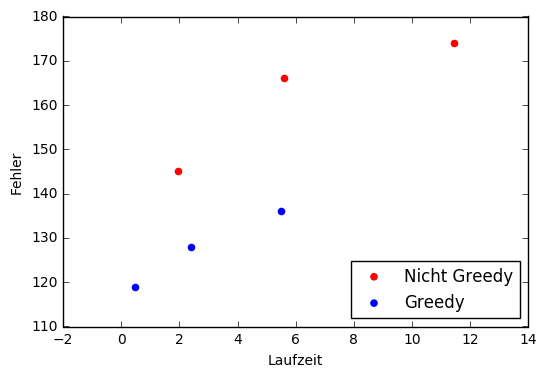

In [275]:
nonGreedy = plt.scatter([r1.best,r3.best,r5.best],[err1,err3,err5], color="red")
greedy = plt.scatter([rRed1.best,rRed3.best,rRed5.best],[errRed1,errRed3,errRed5], color="blue")

plt.xlabel("Laufzeit")
plt.ylabel("Fehler")


plt.legend((nonGreedy, greedy),
           ('Nicht Greedy', 'Greedy'),
           scatterpoints=1,
           loc='lower right')

plt.show()

Der Greedy-Ansatz hat auf Grund des verdichteten Datensatzes eine bessere Laufzeit. Dafür ist aber eine zeitaufwändige Vorberechnung notwendig, um die Verdichtung der Daten durchzuführen.

Der Greedy-Ansatz aus c) ist in allen Fällen weniger Fehleranfällig als der Ansatz aus a).